In this notebook, we are considering the problems IOU and non-max suppresion, used in YOLO algorithm

In [2]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

## Initializing parameters

In [3]:
torch.manual_seed(0)

n=600 #dimensions of our image
n_data=10 #number of bounding boxes for every label
n_labels=5 #number of labels
I=np.zeros((n,n,3), dtype=np.uint8) #initializing the image

Generating random labeled boxes

In [4]:
p1 = torch.randint(0,int(3*n/4),(n_labels,2))
wl=torch.randint(int(n/6),int(n/4),(n_labels,2))
p2=p1+wl
boxes_label=torch.hstack((p1,p2))

Ploting labeled boxes

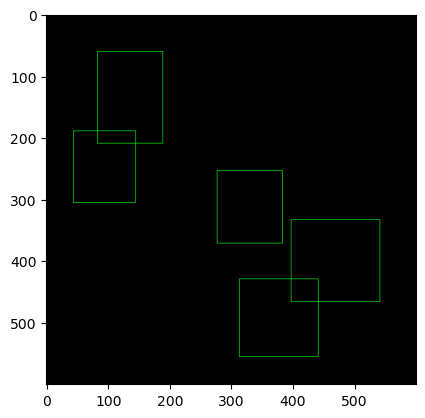

In [5]:
p1_label=zip(p1[:,0], p1[:,1])
p2_label=zip(p2[:,0], p2[:,1])
for i in range(n_labels):
    x1,y1=next(p1_label)
    x1=x1.item()
    y1=y1.item()
    pt1=(x1,y1)
    
    x2,y2=next(p2_label)
    x2=x2.item()
    y2=y2.item()
    pt2=(x2,y2)
    cv2.rectangle(I, pt1, pt2, color=[0, 255,0])
implot=plt.imshow(I)


Generating random bounding boxes

In [6]:
b1=torch.zeros((n_data*n_labels,2), dtype=torch.int32)
for i in range(n_labels):
    p_ch=torch.randint(int(-wl[i,0]/2), int(wl[i,1]/2),(n_data,2))
    b1[i*n_data:(i+1)*n_data,:]=p1[i]+p_ch

b2=b1+torch.randint(int(n/6), int(n/4), (n_data*n_labels,2))
boxes=torch.hstack((b1,b2))

Plotting bounding boxes with the correct labeled bounding boxes

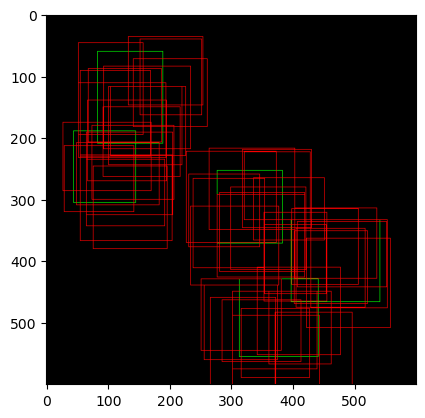

In [7]:
bx1=boxes[...,0]
by1=boxes[...,1]
bx2=boxes[...,2]
by2=boxes[...,3]
#plot boxes
for i in range(boxes.shape[0]):
    pt1=(bx1[i].item(),by1[i].item())
    pt2=(bx2[i].item(),by2[i].item())
    cv2.rectangle(I, pt1, pt2, color=[0,0,255])
I_show=cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
implot=plt.imshow(I_show)

For shortening the plotting code, we will write the following function

In [8]:
def plot(I, pt1, pt2, clr=[0, 0, 255]):
    cv2.rectangle(I, pt1, pt2, color=clr,thickness=1)

The following function will perform the calculations for IOU

In [22]:
def IOU(boxes, boxes_labels, flag=0):
    iou=[]
    I2=np.zeros((n,n,3), dtype=np.uint8) # for non-max
    #extract corners of boxes
    bx1=boxes[...,0]
    by1=boxes[...,1]
    bx2=boxes[...,2]
    by2=boxes[...,3]

    for j in range(boxes_labels.shape[0]):
        
        #extract points of corners of label boxes
        lx1=boxes_labels[j,0]
        ly1=boxes_labels[j,1]
        lx2=boxes_labels[j,2]
        ly2=boxes_labels[j,3]
        
        #calculate mutual rectangles
        x1=torch.max(lx1, bx1)
        y1=torch.max(ly1, by1)
        x2=torch.min(lx2, bx2)
        y2=torch.min(ly2, by2)
        intersection=(x2-x1).clamp(0)*(y2-y1).clamp(0)
        
        #plot intersections
        for i in range(boxes.shape[0]):
            if intersection[i].item()<0.001:
                continue
            else:
                pt1=(x1[i].item(), y1[i].item())
                pt2=(x2[i].item(), y2[i].item())
                cv2.rectangle(I, pt1, pt2, [255,0,0])
        
        #calculate IOU    
        area_label=torch.abs((lx2-lx1)*(ly2-ly1))
        area=torch.abs((bx2-bx1)*(by2-by1))
        union= area+area_label-intersection
        ioui=intersection/union
        plot(I2, (lx1.item(), ly1.item()), (lx2.item(), ly2.item()), clr=[0, 255, 0])
        
        if flag==1:
            non_max(I2,boxes,ioui,0.6)
        else:
            imx=torch.argmax(ioui).item()
            only_max(I2, boxes, imx)    #theses we will use later
        
        
        iou.append(ioui)
    I2_show=cv2.cvtColor(I2,cv2.COLOR_BGR2RGB)
    plot2=plt.imshow(I2_show)
    return iou

And the non-max supperssion. In this code we are suppressing all bounding boxes which have IOU ratio less than a specific threshold.

In [23]:
def non_max(I,boxes,iou,thresh):
    
    for i in range(boxes.shape[0]):
        if iou[i]>thresh:
            pt1x=boxes[i,0].item()
            pt1y=boxes[i,1].item()
            pt2x=boxes[i,2].item()
            pt2y=boxes[i,3].item()
            pt1=(pt1x, pt1y)
            pt2=(pt2x, pt2y)
            plot(I, pt1, pt2)

To run the algorithm

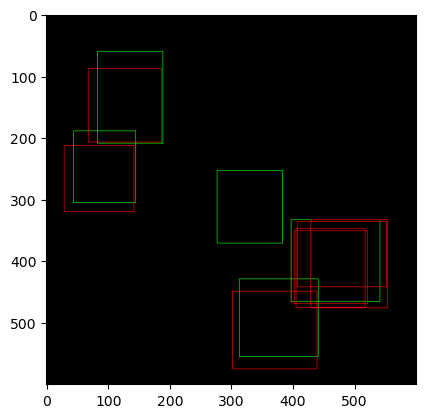

In [24]:
iou=IOU(boxes, boxes_label,1)

We can see that for most bounding boxes, we could detect the closest bounding boxes, while for others, the algorithm resulting in multiple solutions. To solve this we can take only the bounding box with the maximum value of IOU instead of performing a threshold over IOU.

In [25]:
def only_max(I,boxes,imx):
    pt1=(boxes[imx,0].item(),boxes[imx,1].item())
    pt2=(boxes[imx,2].item(),boxes[imx,3].item())
    plot(I,pt1,pt2)

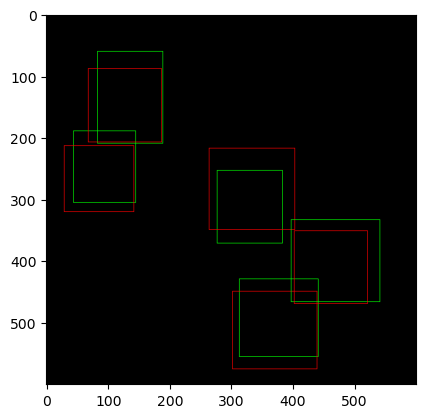

In [26]:
iou=IOU(boxes, boxes_label,0)

We got the desired result.